# Fe K $\alpha$ line from SN1006

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
m_p = 938.272 #MeV
m_e = 0.511  #MeV
c = 3e10 #cm/s
hPlanck = 4.135e-21 #MeV s
M_sol = 2e30 # kg
m_H = 1.67e-27 # kg
m_avg = 1.4*m_H
#sig_sb = 3.5394474508e7 # erg cm-2 s-1 K-4
sig_sb = 3.5394474508e7 * 6.242e11 # eV cm-2 s-1 K-4

In [6]:
def velocity(E_kin, rest_mass):
    E_kin = E_kin
    rest_mass = rest_mass
    gamma = 1+(E_kin/rest_mass)
    beta = np.sqrt(1-(1/(gamma**2)))
    v = c*beta
    return v, beta, gamma

## CR spectrum

$J_{CR}(T_i) = A_i(T_i^2 + 2T_im_ic^2)^{-\frac{\delta}{2}}exp\left(-\frac{T_i}{T_i^c}\right)$
where $A_i$ is the normalisation factor ($\mathrm{eV^{-1}cm^{-2}s^{-1}sr^{-1}}$), $T_i$ is the kinetic energy of the CR particle of species $i$, $T_i^c$ is the cut-off energy, $m_i$ is the mass of the CR particle $i$, all of these quantities in $\mathrm{GeV}$ and $\delta$ is the power-law index.

In [13]:
def J_CRp(T_p, del_p, Ap, Tp_c):
    # Gives spectrum in MeV-1 cm-2 s-1 sr-1
    p2 = (T_p ** 2) + (2 * T_p * m_p) # MeV2
    p2_GeV = 1e-6 * p2 #GeV2
    return Ap * np.power(p2_GeV, -del_p / 2) * np.exp(- T_p / Tp_c)

def J_CRe(T_e, del_e, Ae, Te_c):
    # Gives spectrum in MeV-1 cm-2 s-1 sr-1
    p2 = (T_e ** 2) + (2 * T_e * m_e) #MeV2
    p2_GeV = 1e-6 * p2
    return Ae * np.power(p2_GeV, -del_e / 2) * np.exp(- T_e / Te_c)

Check with Minh:

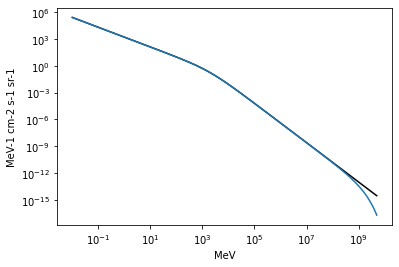

In [18]:
pspectrum_Minh = np.genfromtxt(open("spectrum_SN1006.txt", "r"), delimiter=',') 
E_MeV, intensity = pspectrum_Minh[:,0] * 1e-6, pspectrum_Minh[:,1] * 1e6
plt.plot(E_MeV, intensity, color='black')
plt.plot(E_MeV, np.array([J_CRp(E, 2.2, 1.63, 1e9) for E in E_MeV]))
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MeV")
plt.ylabel("MeV-1 cm-2 s-1 sr-1")
plt.show()

## Multi-wavelength fit

In order to find the normalisation and cut-off values for the CR particle spectra, we fit multiwavelength data (radio, gamma) from the SN1006 region.

Radio: synchrotron emissions from electrons

$\Phi_{syn} = \frac{\sqrt{3}}{2\pi}\frac{e^3B_0}{m_ec^2}\frac{1}{\hbar{E}}\int_0^{\infty}N_{CRe}(T_e)R\left(\frac{T_e}{E_c(T_e)}\right)\,dT_e$

Gamma: 
pion decay from protons

$\Phi_{\gamma, p}(E_\gamma) = 4\pi{n_H}\int\frac{d\sigma}{dE_\gamma}(T_p, E_\gamma)N_{CRp}(T_p)\,dT_p$ 

inverse Compton and relativistic Bremsstrahlung from electrons 

$\Phi_{\gamma, e}(E_\gamma) = cn_H\int\sigma_{brem}(E_\gamma, T_e)N_{CRe}(T_e)\,dT_e + \int\frac{dN_{iso}}{d{\omega}dt}(T_e, E_\gamma)N_{CRe}(T_e)\,dT_e$


In [20]:
from CRp_gamma import Phi_pp_gamma 
# Takes CRp spectrum in MeV-1 cm-2 s-1 sr-1 and returns gamma spectrum in MeV-1 cm-3 s-1
from CRe_gamma_radio import Phi_e_syn, Phi_e_rel_brem, Phi_e_IC
# Take CRe spectrum in MeV-1 cm-3 and returns gamma spectrum in MeV-1 cm-3 s-1

In [4]:
def N_CRp(T_p, del_p, Ap, Tp_c):
    # Gives particle density in MeV-1 cm-3
    v_p, _, _ = velocity(T_p, m_p)
    return (4 * np.pi / v_p) * J_CRp(T_p, del_p, Ap, Tp_c)

def N_CRe(T_e, del_e, Ae, Te_c):
    # Gives particle density in MeV-1 cm-3
    v_e, _, _ = velocity(T_e, m_e)
    return (4 * np.pi / v_e) * J_CRp(T_e, del_e, Ae, Te_c)

Loading data

In [7]:
radio_data = np.genfromtxt(open("SN1006_data_radio.txt", "r"), delimiter=',') # in Hz and Jy Hz
xray_data = np.genfromtxt(open("SN1006_data_suzaku.txt", "r"), delimiter=',') # in eV and eV cm-2 s-1
fermi_data = np.genfromtxt(open("SN1006_data_SW_FERMI.txt", "r"), delimiter=',') # in GeV and erg cm-2 s-1
fermi_upper_data = np.genfromtxt(open("SN1006_data_SW_upper_FERMI_Acero2015.txt", "r"), delimiter=',') # in eV and erg cm-2 s-1
hess_data = np.genfromtxt(open("SN1006_data_SW_HESS.txt", "r"), delimiter=',') # in eV and erg cm-2 s-1

Converting all to units $\mathrm{MeV}$ and $\mathrm{erg.cm^{-2}.s^{-1}}$

In [23]:
Er, Phi_radio = radio_data[:, 0] * hPlanck, 1e-23 * radio_data[:, 1] 
Ex, Phi_xray = xray_data[:, 0] * 1e-6, xray_data[:, 1] * 1.602e-12
Ef, Efm, Efp, Phi_fermi, Phi_fp, Phi_fm = fermi_data[:, 0] * 1e3, fermi_data[:, 1] * 1e3, fermi_data[:, 2] * 1e3, fermi_data[:, 3], fermi_data[:, 4], fermi_data[:, 5]
Efu, Phi_fermi_up = fermi_upper_data[:, 0] * 1e-6, fermi_upper_data[:, 1]
Eh, Phi_hp, Phi_hm = hess_data[:, 0] * 1e-6, hess_data[:, 1], hess_data[:, 2] 

Plot data

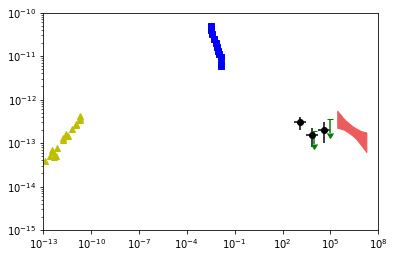

In [24]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.xscale('log')
plt.yscale('log')
#plt.xlabel(r'$E_{\gamma}\mathrm{(eV)}$')
#plt.ylabel(r'$E^2_\gamma\phi(E_\gamma)\mathrm{(erg cm$^{-2}$ s$^{-1}$)}$')
plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

Gamma-ray emissions

In [5]:
n_cl = 0.38 #0.5 #cm-3 or 0.38 cm-3
M_cl = 0.4 * M_sol
R_cl = 2 * 3e18 #cm
V_cl = (4 / 3) * np.pi * (R_cl ** 3)


n_sh = 0.12 #cm-3
M_sh = 0.5 * M_sol
xf = 0.25
R_sh = 8 * 3e18 #cm
V_sh = (xf / 3) * np.pi * (R_sh ** 3)
B_sh_1 = 1e-2 #mG
B_sh_2 = 0.1 #mG

d = 2.2 * 3e21 #cm

sigma_sb=3.5394474508e7 #eV cm^-2 s^-1 K^-4
#T_CMB, w_CMB = 2.72, 4.0 * sigma_sb * pow(2.72,4)/3.0e10 #K, eV cm-3
T_CMB, w_CMB = 2.72, 0.261
k_CMB = w_CMB * c / (sigma_sb * (T_CMB ** 4))
T_NIR, w_NIR = 30.0, 0.5
k_NIR = w_NIR * c / (sigma_sb * (T_NIR ** 4))
T_FIR, w_FIR = 3000.0, 1.0
k_FIR = w_FIR * c / (sigma_sb * (T_FIR ** 4))

E_g_list = np.logspace(-13, 8, 100) #MeV

emi_pre_cl = V_cl / (4 * np.pi * (d ** 2)) # cm
emi_pre_sh = V_sh / (4 * np.pi * (d ** 2)) # cm

In [26]:
del_p, Ap, Tp_c = 2.2, 1.63, 1e9
del_e, Ae, Te_c = 2.2, 7.47e-3, 1e7

def J_p(T_p):
    return J_CRp(T_p, del_p=del_p, Ap=Ap, Tp_c=Tp_c) # MeV-1 cm-2 s-1 sr-1

def N_p(T_p):
    return N_CRp(T_p, del_p=del_p, Ap=Ap, Tp_c=Tp_c) # MeV-1 cm-3

def N_e(T_e):
    return N_CRe(T_e, del_e=del_e, Ae=Ae, Te_c=Te_c) # MeV-1 cm-3

def J_e(T_e):
    return J_CRe(T_e, del_e=del_e, Ae=Ae, Te_c=Te_c) # MeV-1 cm-2 s-1 sr-1

def N_e_m(p):
    T_e = np.sqrt((p ** 2) + (m_e ** 2)) - m_e
    dT_on_dp = p ** 2 / (T_e + m_e)
    return N_CRe(T_e, del_e=del_e, Ae=Ae, Te_c=Te_c) * dT_on_dp / (4 * np.pi * (p ** 2))

Phi_gamma_p_cl = np.array([E_g * E_g * emi_pre_cl * Phi_pp_gamma(E_g, J_p, n_cl) * 1.602e-6 for E_g in E_g_list])
Phi_gamma_e_cl = np.array([E_g * E_g * emi_pre_cl * Phi_e_rel_brem(E_g, N_e, n_cl) * 1.602e-6 for E_g in E_g_list])
Phi_gamma_cl = Phi_gamma_p_cl + Phi_gamma_e_cl

Phi_gamma_p_sh = np.array([E_g * E_g * emi_pre_sh * Phi_pp_gamma(E_g, J_p, n_sh) * 1.602e-6 for E_g in E_g_list])
Phi_gamma_e_sh = np.array([E_g * E_g * emi_pre_sh * Phi_e_rel_brem(E_g, N_e, n_sh) * 1.602e-6 for E_g in E_g_list])
Phi_gamma_sh = Phi_gamma_p_sh + Phi_gamma_e_sh

Phi_gamma_e_IC = np.array([E_g * E_g * (emi_pre_cl) * (Phi_e_IC(E_g, N_e, T_CMB, k_CMB) + Phi_e_IC(E_g, N_e, T_NIR, k_NIR) + Phi_e_IC(E_g, N_e, T_FIR, k_FIR)) * 1.602e-6 for E_g in E_g_list])
#Phi_gamma_e_IC = np.array([E_g * E_g * (emi_pre_cl + emi_pre_sh) * (Phi_e_IC(E_g, N_e, T_CMB, 1)) * 1.602e-6 for E_g in E_g_list])


TypeError: Phi_pp_gamma() missing 3 required positional arguments: 'Ap', 'Tp_c', and 'n'

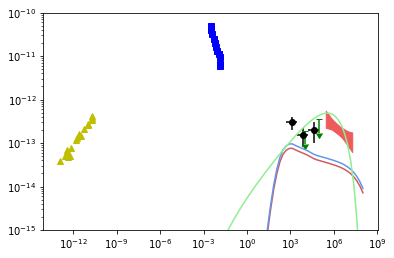

In [ ]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(E_g_list, Phi_gamma_cl, color='indianred')
plt.plot(E_g_list, Phi_gamma_sh, color='cornflowerblue')
plt.plot(E_g_list, Phi_gamma_e_IC, color='lightgreen')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:418: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


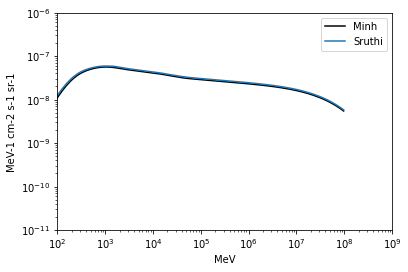

In [ ]:
pgamma_Minh = np.genfromtxt(open("gamma_SN1006.txt", "r"), delimiter=',') 
E_MeV, gamma_flux = pgamma_Minh[:,0] * 1e-6, pgamma_Minh[:,1] * 1e-6
Phi_gamma_p_sh = np.array([E * E * emi_pre_sh * Phi_pp_gamma(E, J_p, n_sh) for E in E_MeV])
plt.plot(E_MeV, gamma_flux, color='black', label='Minh')
plt.plot(E_MeV, Phi_gamma_p_sh, label='Sruthi')
plt.xlim([1e2, 1e9])
plt.ylim([1e-11, 1e-6])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MeV")
plt.ylabel("MeV-1 cm-2 s-1 sr-1")
plt.show()

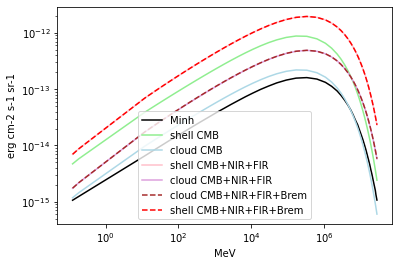

In [ ]:
IC_Minh = np.genfromtxt(open("IC_SN1006.txt", "r"), delimiter=',') 
E_MeV, IC_flux = IC_Minh[:,0] * 1e-6, IC_Minh[:,1]
Phi_IC_cl_CMB = np.array([E * E * emi_pre_cl * Phi_e_IC(E, N_e, T_CMB, k_CMB) * 1.602e-6 for E in E_MeV])
Phi_IC_sh_CMB = np.array([E * E * emi_pre_sh * Phi_e_IC(E, N_e, T_CMB, k_CMB) * 1.602e-6 for E in E_MeV])
Phi_IC_cl = np.array([E * E * emi_pre_cl * (Phi_e_IC(E, N_e, T_CMB, k_CMB) + Phi_e_IC(E, N_e, T_NIR, k_NIR) + Phi_e_IC(E, N_e, T_FIR, k_FIR)) * 1.602e-6 for E in E_MeV])
Phi_IC_sh = np.array([E * E * emi_pre_sh * (Phi_e_IC(E, N_e, T_CMB, k_CMB) + Phi_e_IC(E, N_e, T_NIR, k_NIR) + Phi_e_IC(E, N_e, T_FIR, k_FIR)) * 1.602e-6 for E in E_MeV])
Phi_ICBrem_cl = np.array([E * E * emi_pre_cl * (Phi_e_IC(E, N_e, T_CMB, k_CMB) + Phi_e_IC(E, N_e, T_NIR, k_NIR) + Phi_e_IC(E, N_e, T_FIR, k_FIR) + Phi_e_rel_brem(E, N_e, n_cl)) * 1.602e-6 for E in E_MeV])
Phi_ICBrem_sh = np.array([E * E * emi_pre_sh * (Phi_e_IC(E, N_e, T_CMB, k_CMB) + Phi_e_IC(E, N_e, T_NIR, k_NIR) + Phi_e_IC(E, N_e, T_FIR, k_FIR) + Phi_e_rel_brem(E, N_e, n_sh)) * 1.602e-6 for E in E_MeV])
plt.plot(E_MeV, IC_flux, color='black', label='Minh')
plt.plot(E_MeV, Phi_IC_sh_CMB, color='lightgreen', label='shell CMB')
plt.plot(E_MeV, Phi_IC_cl_CMB, color='lightblue', label='cloud CMB')
plt.plot(E_MeV, Phi_IC_sh, color='pink', label='shell CMB+NIR+FIR')
plt.plot(E_MeV, Phi_IC_cl, color='plum', label='cloud CMB+NIR+FIR')
plt.plot(E_MeV, Phi_ICBrem_cl, color='brown', label='cloud CMB+NIR+FIR+Brem', linestyle='dashed')
plt.plot(E_MeV, Phi_ICBrem_sh, color='red', label='shell CMB+NIR+FIR+Brem', linestyle='dashed')
#plt.xlim([1e2, 1e9])
#plt.ylim([1e-11, 1e-6])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MeV")
plt.ylabel("erg cm-2 s-1 sr-1")
plt.show()

/Users/ravikularaman/VScode/SN1006/sn-1006/CRe_gamma_radio.py:87: RuntimeWarning: invalid value encountered in log
  phi_1 = np.log((2*E_e/m_e)*(E_e-E_gamma)/E_gamma)-(1/2)
/Users/ravikularaman/VScode/SN1006/sn-1006/CRe_gamma_radio.py:96: RuntimeWarning: invalid value encountered in log
  log_term = np.log((2 * E_e / m_e) * ((E_e - E_gamma) / E_gamma))


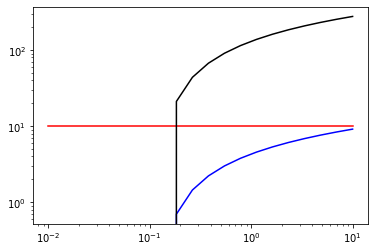

In [27]:
from CRe_gamma_radio import sigma_scat_diff, sigma_scat_simple, sigma_scat_schlickeiser

plt.plot(np.logspace(-2, 1, 20), [1e-3 * sigma_scat_diff(30e-3, T) * 1e28 for T in np.logspace(-2, 1, 20)], color='blue')
plt.plot(np.logspace(-2, 1, 20), [1e-3 * sigma_scat_simple(30e-3) * 1e28 for T in np.logspace(-2, 1, 20)], color='red')
plt.plot(np.logspace(-2, 1, 20), [sigma_scat_schlickeiser(30e-3, T) * 1e28 for T in np.logspace(-2, 1, 20)], color='black')
plt.xscale("log")
plt.yscale("log")

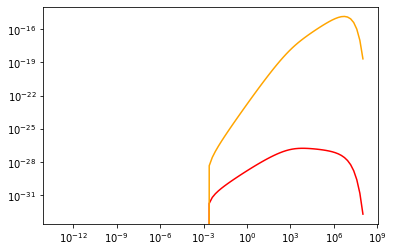

In [29]:
from CRe_gamma_radio import Phi_e_rel_brem, Phi_e_rel_brem_sch

plt.plot(E_g_list, [Phi_e_rel_brem(E, N_CRe, del_e=2.2, Ae= 7.47e-3, Te_c =1e7, n=1) for E in E_g_list], color='red')
plt.plot(E_g_list, [Phi_e_rel_brem_sch(E, N_CRe, del_e=2.2, Ae= 7.47e-3, Te_c =1e7, n=1) for E in E_g_list], 'orange')
plt.xscale("log")
plt.yscale("log")
plt.show()

In [5]:
alpha = 1/137
h_bar_erg = 1.0545919e-27 #erg s
e = 4.797e-10 # in cm^3/2 g^1/2 s-1
c = 3e10
alpha_2 = (e ** 2) / (h_bar_erg * c)
print(alpha)
print(alpha_2)

0.0072992700729927005
0.007273337676877662


Radio emissions

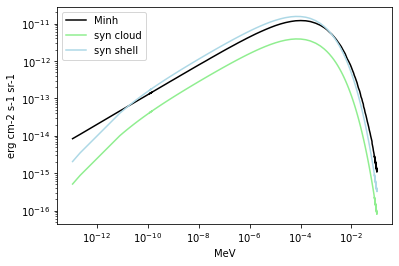

In [18]:
syn_Minh = np.genfromtxt(open("synchrotron_SN1006.txt", "r"), delimiter=',') 
E_MeV, syn_flux = syn_Minh[:, 0] * 1e-6, syn_Minh[:, 1]
Phi_syn_cl = np.array([E * E * (emi_pre_cl) * Phi_syn(E, N_e, 26e-3) * 1.602e-6 for E in E_MeV])
Phi_syn_sh = np.array([E * E * (emi_pre_sh) * Phi_syn(E, N_e, 26e-3) * 1.602e-6 for E in E_MeV])
#Phi_syn_bis = np.array([E * E * emi_pre_cl * Phi_syn_2(E, N_e_m, 26e-3) * 1.602e-6 for E in E_MeV])
#Phi_syn_bis3 = np.array([E * E * emi_pre_cl * Phi_syn_3(E, N_e, 26e-3) * 1.602e-6 for E in E_MeV])
plt.plot(E_MeV, syn_flux, label='Minh', color='black')
plt.plot(E_MeV, Phi_syn_cl, label='syn cloud', color='lightgreen')
plt.plot(E_MeV, Phi_syn_sh, label='syn shell', color='lightblue')
#plt.plot(E_MeV, Phi_syn_bis, label='syn 2', color='indianred')
#plt.plot(E_MeV, Phi_syn_bis3, label='syn 3', color='purple')
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MeV")
plt.ylabel("erg cm-2 s-1 sr-1")
plt.show()

In [11]:
Phi_radio_syn_cl = np.array([E * E * (emi_pre_cl) * Phi_syn(E, N_e, 26e-3) * 1.602e-6 for E in E_g_list])
Phi_radio_syn_sh = np.array([E * E * (emi_pre_sh) * Phi_syn(E, N_e, 26e-3) * 1.602e-6 for E in E_g_list])
Phi_radio_e_syn = Phi_radio_syn_cl + Phi_radio_syn_sh

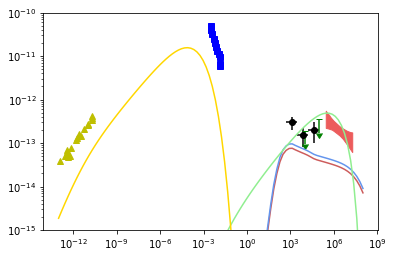

In [36]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(E_g_list, Phi_gamma_cl, color='indianred')
plt.plot(E_g_list, Phi_gamma_sh, color='cornflowerblue')
plt.plot(E_g_list, Phi_gamma_e_IC, color='lightgreen')
plt.plot(E_g_list, Phi_radio_syn_sh, color='gold')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

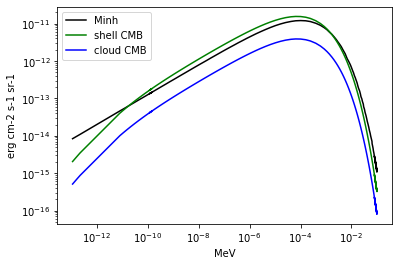

In [21]:
syn_Minh = np.genfromtxt(open("synchrotron_SN1006.txt", "r"), delimiter=',') 
E_MeV, syn_flux = syn_Minh[:,0] * 1e-6, syn_Minh[:,1]
Phi_syn_cl = np.array([E * E * (emi_pre_cl) * Phi_syn(E, N_e, 26e-3) * 1.602e-6 for E in E_MeV])
Phi_syn_sh = np.array([E * E * (emi_pre_sh) * Phi_syn(E, N_e, 26e-3) * 1.602e-6 for E in E_MeV])
plt.plot(E_MeV, syn_flux, color='black', label='Minh')
plt.plot(E_MeV, Phi_syn_sh, color='green', label='shell CMB')
plt.plot(E_MeV, Phi_syn_cl, color='blue', label='cloud CMB')
#plt.xlim([1e2, 1e9])
#plt.ylim([1e-11, 1e-6])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MeV")
plt.ylabel("erg cm-2 s-1 sr-1")
plt.show()

X-ray fit

In [12]:
def Xray_fit(E):
    return 2.3e-12 * np.power(E/(1e-3), -3)

In [13]:
Phi_x_fit = np.array([Xray_fit(E) for E in E_g_list])

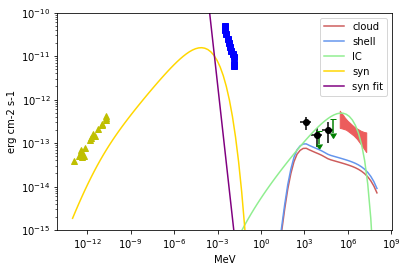

In [37]:
plt.plot(Er, Phi_radio, 'y^')
plt.plot(Ex, Phi_xray, 'bs')
plt.errorbar(Ef, Phi_fermi, yerr=[Phi_fermi-Phi_fm,Phi_fp-Phi_fermi], xerr=[Ef-Efm,Efp-Ef], fmt='ko')
plt.errorbar(Efu, Phi_fermi_up, yerr=0.5 * Phi_fermi_up, linestyle='none', marker='_', color="green", uplims=True)
plt.fill_between(Eh, Phi_hm, Phi_hp, color=[(236.0/255.0,92.0/255.0,92.0/255.0)])
plt.plot(E_g_list, Phi_gamma_cl, color='indianred', label='cloud')
plt.plot(E_g_list, Phi_gamma_sh, color='cornflowerblue', label='shell')
plt.plot(E_g_list, Phi_gamma_e_IC, color='lightgreen', label='IC')
plt.plot(E_g_list, Phi_radio_syn_sh, color='gold', label='syn')
plt.plot(E_g_list, Phi_x_fit, color='purple', label='syn fit')
plt.legend()
plt.xlabel('MeV')
plt.ylabel('erg cm-2 s-1')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(1.0e-13,1.0e8)
plt.ylim(1.0e-15,1.0e-10)
plt.show()

X-ray emissions (6.4 keV line)

In [14]:
from FeKalpha_CR import sigma_64_p, sigma_64_e, Flux_Fe_64_p, Flux_Fe_64_e

<function matplotlib.pyplot.show(close=None, block=None)>

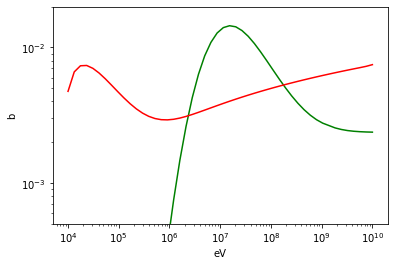

In [15]:
sig_64p = np.array([sigma_64_p(E) * 1e24 for E in np.logspace(-2, 4, 50)])
sig_64e = np.array([sigma_64_e(E) * 1e24 for E in np.logspace(-2, 4, 50)])
plt.plot(np.logspace(4, 10, 50), sig_64p, color='green')
plt.plot(np.logspace(4, 10, 50), sig_64e, color='red')
plt.ylim([5e-4, 2e-2])
plt.xlabel("eV")
plt.ylabel("b")
plt.xscale("log")
plt.yscale("log")
plt.show

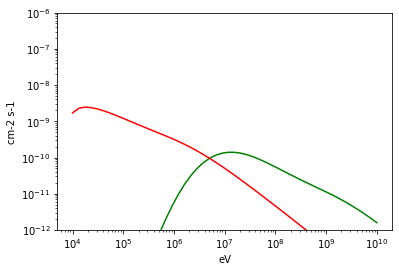

In [34]:
norm = 3e-5 * M_cl / ((d ** 2))
diff_64_p = (M_cl / (m_avg * (d**2))) * np.array([T * sigma_64_p(T) * J_p(T) for T in np.logspace(-2, 4, 50)])
diff_64_e = (M_cl / (m_avg * (d**2))) * np.array([T * sigma_64_e(T) * J_e(T) for T in np.logspace(-2, 4, 50)])  
plt.plot(np.logspace(4, 10, 50), diff_64_p, color='green')
plt.plot(np.logspace(4, 10, 50), diff_64_e, color='red')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("eV")
plt.ylabel("cm-2 s-1")  
plt.ylim([1e-12, 1e-6])
plt.show()

In [16]:
I_64_p = 3e-5 * Flux_Fe_64_p(1e-2, N_p, 0.4 * M_sol) / (4 * np.pi * (d ** 2))
I_64_e = 3e-5 * Flux_Fe_64_e(1e-2, N_e, 0.4 * M_sol) / (4 * np.pi * (d ** 2))
print(I_64_p)
print(I_64_e)

1.4130828534167684e-14
9.185327037602245e-17


In [9]:
from CRe_gamma_radio import Phi_e_rel_brem, Phi_e_IC, Phi_e_syn
from CRp_gamma import Phi_pp_gamma

PP gamma check

In [10]:
del_p, Ap, Tp_c = 2.2, 1.63, 1e9
del_e, Ae, Te_c = 2.2, 7.47e-3, 1e7

In [19]:
pgamma_Minh = np.genfromtxt(open("gamma_SN1006.txt", "r"), delimiter=',') 
E_MeV = pgamma_Minh[:,0] * 1e-6, 
gamma_flux = 4* pi * E_MeV * E_MeV * pgamma_Minh[:,1] * 1e-6
Phi_p_gamma_cl_22 = emi_pre_cl * np.array([Phi_pp_gamma(E, N_CRp, del_p, Ap, Tp_c, n_cl) for E in E_MeV])
Phi_p_gamma_sh_22 = emi_pre_sh * np.array([Phi_pp_gamma(E, N_CRp, del_p, Ap, Tp_c, n_sh) for E in E_MeV])

In [18]:
#plt.plot(E_MeV, gamma_flux, color='black', label='Minh')
plt.plot(E_MeV, Phi_p_gamma_sh_22, label='Sruthi sh')
plt.plot(E_MeV, Phi_p_gamma_cl_22, label='Sruthi cl')
#plt.xlim([1e2, 1e9])
#plt.ylim([1e-11, 1e-6])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("MeV")
plt.ylabel("MeV-1 cm-2 s-1 sr-1")
plt.show()

/Users/ravikularaman/VScode/SN1006/sn-1006/CRp_gamma.py:419: RuntimeWarning: invalid value encountered in double_scalars
  F_p = (num**beta)/(den**gamma)


KeyboardInterrupt: 

In [ ]:
from CRe_gamma_radio import sigma_scat